In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")


display(hits)


,event_id,x,y,z,energy
0,1000,-60.473331,61.174706,-190.092606,0.002500
1,1000,-58.959297,62.646202,-189.701813,0.004575
2,1000,-61.557613,59.296467,-188.970398,0.031325
3,1000,-55.261448,65.182266,-188.487228,0.046225
4,1000,-53.602306,65.895462,-187.851212,0.000525
...,...,...,...,...,...
2264514,6299,-76.239838,-71.066895,220.474365,0.124675
2264515,6299,-78.100128,-70.808456,221.888367,0.001375
2264516,6299,-76.734650,-70.751152,222.119293,0.037975
2264517,6299,-78.452171,-70.575264,222.679504,0.008550


Energy Sum:  2.4584


,x,y,z,energy
0,-17.574072,-134.463089,-97.767357,0.002200
1,-16.716864,-135.536362,-99.530983,0.008175
2,-16.506687,-131.877335,-96.945824,0.012675
3,-15.559255,-158.047394,-103.053123,0.005325
4,-15.282230,-158.538773,-99.709793,0.010050
...,...,...,...,...
227,56.743725,-151.155762,-80.864990,0.023525
228,56.904564,-148.471985,-67.538887,0.015300
229,56.940891,-149.475616,-72.014229,0.007525
230,57.042156,-150.107376,-77.417328,0.004500


Vertex Index is: 52
{52: [64, 53], 64: [52, 69], 53: [52, 57], 0: [1, 2], 1: [0, 11], 2: [0, 16], 3: [12, 4], 12: [3, 14], 4: [7, 3], 7: [4, 5], 5: [9, 7], 9: [5, 6], 6: [8, 9], 8: [6, 10], 10: [13, 8], 13: [10, 24], 11: [15, 1], 15: [11, 20], 14: [12, 26], 16: [25, 2], 25: [16, 28], 17: [18, 27], 18: [17, 19], 19: [18, 21], 20: [23, 15], 23: [20, 22], 21: [19, 22], 22: [21, 23], 24: [13, 29], 26: [30, 14], 30: [26, 31], 27: [17, 33], 28: [25, 29], 29: [28, 24], 31: [30, 32], 32: [34, 31], 34: [32, 36], 33: [35, 27], 35: [33, 43], 36: [34, 39], 37: [38, 41], 38: [37, 40], 39: [36, 42], 40: [38, 44], 41: [46, 37], 46: [41, 50], 42: [48, 39], 48: [42, 54], 43: [47, 35], 47: [43, 51], 44: [45, 40], 45: [44, 49], 49: [45, 56], 50: [46, 54], 54: [48, 50], 56: [49, 61], 51: [55, 47], 55: [51, 68], 57: [53, 59], 61: [56, 66], 59: [57, 60], 58: [62, 66], 62: [58, 63], 60: [59, 65], 66: [61, 58], 63: [62], 65: [67, 60], 67: [65, 70], 70: [67, 74], 68: [73, 55], 73: [68, 76], 69: [64, 71], 71: [

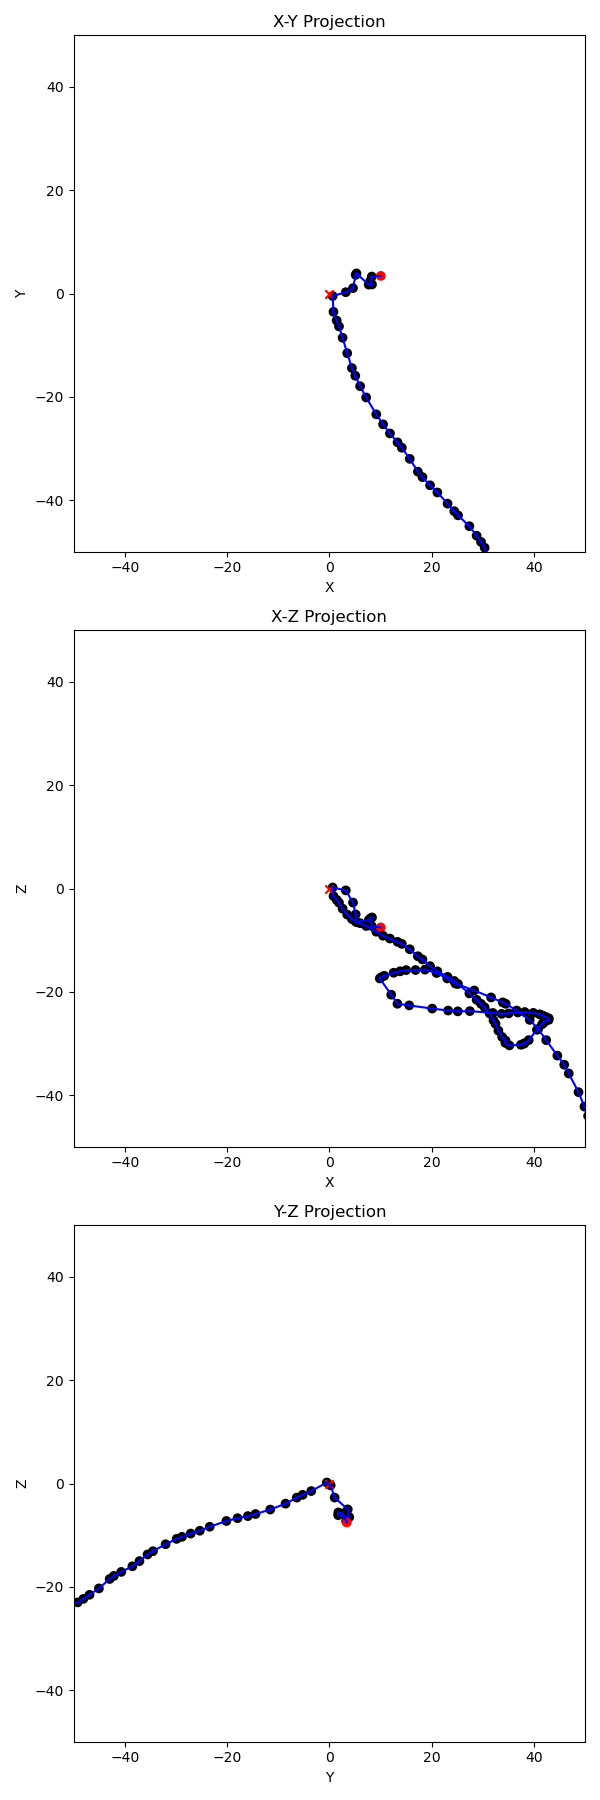

In [18]:
%matplotlib widget

data = hits[hits.event_id ==1820]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if curr_node_idx in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    

# Helper function for testing for closed loops
def Testcycle(curr_node, conn_node ,connected_nodes_, connections_, connection_count_):

    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes_)
    temp_connections      = copy.deepcopy(connections_)
    temp_connection_count = copy.deepcopy(connection_count_)

    # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
    UpdateConnections(curr_node, conn_node, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(curr_node, conn_node, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []

    return cycle


connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break

print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

{'id': 0, 'start': 63, 'end': 84, 'nodes': [63, 62, 58, 66, 61, 56, 49, 45, 44, 40, 38, 37, 41, 46, 50, 54, 48, 42, 39, 36, 34, 32, 31, 30, 26, 14, 12, 3, 4, 7, 5, 9, 6, 8, 10, 13, 24, 29, 28, 25, 16, 2, 0, 1, 11, 15, 20, 23, 22, 21, 19, 18, 17, 27, 33, 35, 43, 47, 51, 55, 68, 73, 76, 82, 88, 96, 101, 113, 117, 118, 121, 122, 124, 126, 129, 135, 140, 138, 134, 133, 136, 137, 130, 127, 132, 142, 146, 151, 156, 158, 164, 171, 177, 181, 187, 194, 203, 207, 208, 210, 212, 214, 216, 218, 220, 223, 224, 225, 227, 230, 231, 229, 228, 226, 222, 221, 219, 217, 215, 213, 211, 209, 206, 205, 204, 200, 190, 186, 178, 174, 170, 162, 154, 148, 143, 139, 125, 119, 114, 102, 98, 87, 85, 83, 94, 99, 115, 131, 145, 149, 153, 163, 168, 175, 179, 184, 188, 191, 193, 199, 202, 201, 197, 195, 192, 189, 185, 183, 182, 180, 176, 172, 173, 169, 167, 166, 165, 161, 159, 157, 155, 152, 150, 147, 144, 141, 128, 123, 120, 116, 110, 100, 90, 86, 81, 75, 74, 70, 67, 65, 60, 59, 57, 53, 52, 64, 69, 71, 72, 77, 80, 78

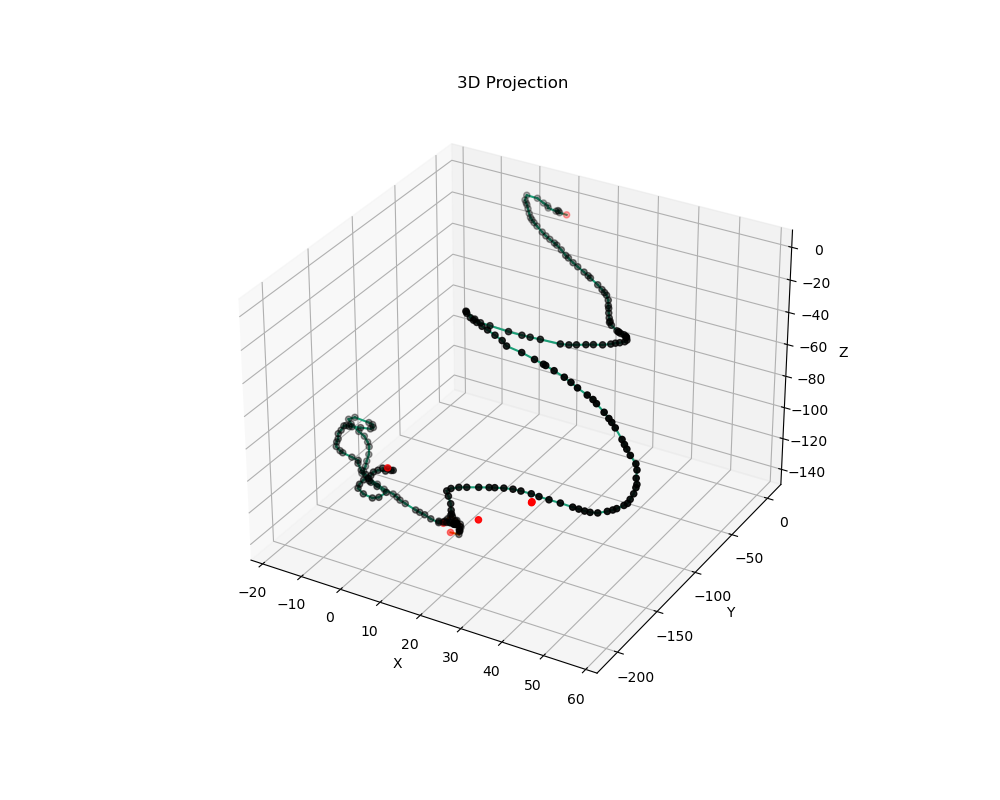

In [19]:
# Track building

# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]


    print("Error in pathing...")
    return path

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)

# Get the length and energy of a track
def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    # Return the hit if there is only one node
    if len(path) == 0:
        return 0,data.iloc[path[0]]['energy']

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), total_energy
    # return round(total_length, 3), round(total_energy, 3)


# Get the length and energy of a track
def GetMeanNodeDist(Tracks):

    nodedists = []

    for track in Tracks:

        nodes = track["nodes"]
        if (len(nodes) == 1):
            continue

        for n in range(len(nodes) - 1):

            point1 = data.iloc[nodes[n]]
            point2 = data.iloc[nodes[n + 1]]
            
            distance = calculate_distance(point1, point2)
            nodedists.append(distance)

    return round(np.mean(nodedists), 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))


In [20]:
print(GetMeanNodeDist(Tracks))

dist_threshold = 4*GetMeanNodeDist(Tracks)
# dist_threshold = 10

2.693


Killing Track:  0
New Track ID is: 5
New Track ID is: 6
New Track ID is: 7
Printing Tracks
{'id': 2, 'start': 93, 'end': 95, 'nodes': [93, 108, 106, 107, 104, 105, 111, 109, 112, 103, 97, 91, 89, 92, 95], 'length': 24.014, 'energy': 0.23137500170560088, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 4, 'start': 196, 'end': 198, 'nodes': [196, 198], 'length': 0.541, 'energy': 0.05239999946206808, 'label': 'track', 'c': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)}
{'id': 5, 'start': 52, 'end': 84, 'nodes': [52, 64, 69, 71, 72, 77, 80, 78, 79, 84], 'length': 18.995, 'energy': 0.24427500320598483, 'label': 'Track1', 'c': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)}
{'id': 6, 'start': 52, 'end': 63, 'nodes': [52, 53, 57, 59, 60, 65, 67, 70, 74, 75, 81, 86, 90, 100, 110, 116, 120, 123, 128, 141, 144, 147, 150, 152, 155, 157, 159, 161, 165, 166, 167, 169, 173, 172, 176, 180, 182, 183, 185, 189, 192, 195, 197, 201

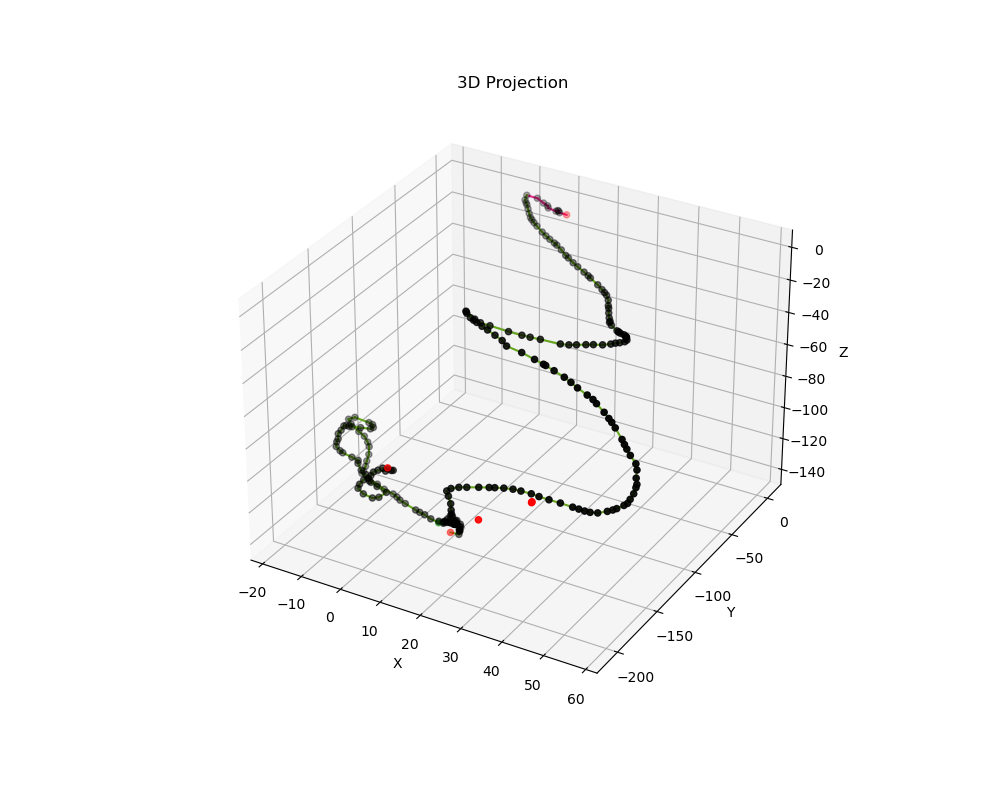

In [21]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def GetTrackDictwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        print("Error cannot join arrays")
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array

# This is
def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks):

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path)
    Delta = {"id":GetUniqueTrackID(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":GetUniqueTrackID(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)

# This adds the same track ID for the delta and the joining track
def AddConnectedTracksnoDelta(curr_track,conn_track, track1_path, UpdatedTracks):

    print("Joining tracks ",curr_track,", ",conn_track)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # Get the same colour as the track
        if (t["id"] == conn_track):
            color = t["c"]
            name = t["label"]

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    Track1 = {"id":conn_track, "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":name,"c":color}
    UpdatedTracks.append(Track1)

# From the track containing the vertex, split the track and add a single node for the vertex
def CreateVertexandSplit(vertexid, trackid, track1_path, track2_path, Tracks):

    # Remove the old tracks from the array
    for index, t in enumerate(Tracks):
        # remove the old track
        if (t["id"] == trackid):
            print("Killing Track: ",t["id"])
            Tracks.pop(index)

    track1_len, track1_e = GetTrackLengthEnergy(track1_path)
    track2_len, track2_e = GetTrackLengthEnergy(track2_path)
    vertex_len, vertex_e = GetTrackLengthEnergy([vertexid])

    color = next(color_cycle)
    Track1 = {"id":GetUniqueTrackID(Tracks), "start":track1_path[0], "end":track1_path[-1], "nodes":track1_path, "length":track1_len, "energy":track1_e,"label":"Track1","c":color}
    Tracks.append(Track1)

    color = next(color_cycle)
    Track2 = {"id":GetUniqueTrackID(Tracks), "start":track2_path[0], "end":track2_path[-1], "nodes":track2_path, "length":track2_len, "energy":track2_e,"label":"Track2","c":color}
    Tracks.append(Track2)

    Vertex = {"id":GetUniqueTrackID(Tracks), "start":vertexid, "end":vertexid, "nodes":[vertexid], "length":vertex_len, "energy":vertex_e,"label":"vertex","c":"r"}
    Tracks.append(Vertex)
   

# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks_):
    
    for index, t in enumerate(UpdatedTracks_):
        
        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            
            # remove the old tracks
            if (t["id"] == curr_track):
                UpdatedTracks.pop(index)

        # Remove the old tracks from the array
        for index, t in enumerate(UpdatedTracks):
            # remove the old tracks
            if (t["id"] == conn_track):
                name=t["label"]
                UpdatedTracks.pop(index)

    # Add the new merged track
    length, energy = GetTrackLengthEnergy(newpath)
    print(newpath[0], newpath[-1], newpath)
    color = next(color_cycle)
    Primary = {"id":GetUniqueTrackID(UpdatedTracks_), "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":length, "energy":energy,"label":name,"c":color}
    UpdatedTracks_.append(Primary)


def SearchDelta(Track_, UpdatedTracks_):
    start = Track_["start"]
    end   = Track_["end"]

    for index, t in enumerate(UpdatedTracks_):
        
        # Check to see if the current track ends matches with any tracks in the updated and it is flagged as a delta
        if (t["start"] == start or t["start"] == end or t["end"] == start or t["end"] == end):
            if (t["label"] == "delta"):
                return True
        
    return False


def GetUniqueTrackID(Tracks_):

    temp_track_id = -1

    for t in Tracks_:
        if temp_track_id <= t["id"]:
            temp_track_id = t["id"]

    print("New Track ID is:",temp_track_id+1)

    return temp_track_id+1



# Any nodes without a connection can be re-added as a track
def AddConnectionlessNodes(connection_count, UpdatedTracks):

    for index, c in enumerate(connection_count):

        if (c == 0):
            hit_energy = data.iloc[index].energy
            Gamma = {"id":GetUniqueTrackID(UpdatedTracks), "start":index, "end":index, "nodes":[index], "length":0, "energy":hit_energy,"label":"gamma","c":"y"}
            UpdatedTracks.append(Gamma)

# First function has a bug, so do it again
# also distribute the vertex energy equally among track 1 and track 2
def FixTrackEnergies(UpdatedTracks):

    vertex_half_energy = 0
    for t in UpdatedTracks:
        if (t["label"] == "vertex"):
            vertex_half_energy = data.iloc[t["start"]].energy/2.0

    # Get the total energy
    for t in UpdatedTracks:
        e_sum = 0

        for node in t["nodes"]:
            e_node = data.iloc[node].energy
            e_sum = e_sum + e_node
        
        # Split the energy equally
        if (t["label"] == "Track1" or t["label"] == "Track2"):
            e_sum = e_sum - vertex_half_energy
        
        # remove energy from the vertex
        if (t["label"] == "vertex"):
            e_sum=0

        t["energy"] = e_sum


# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        # print("vertex:",vertex_index)
        # print("Path1:",trk1_path)
        # print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------

# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    print("Num new tracks:", len(UpdatedTracks))

    if (Track["label"] == "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Skip if we are trying to reconnect to a vertex
    if (end_conn_node == vertex_index):
        print("Trying to connect to vertex, skipping...")
        continue


    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
       newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
       UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks)
       UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
       print("node-node connection")
       continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break

    # Combine the tracks
    AddConnectedTracksnoDelta(curr_track, con_track, Track["nodes"], UpdatedTracks)



# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, UpdatedTracks)
FixTrackEnergies(UpdatedTracks)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



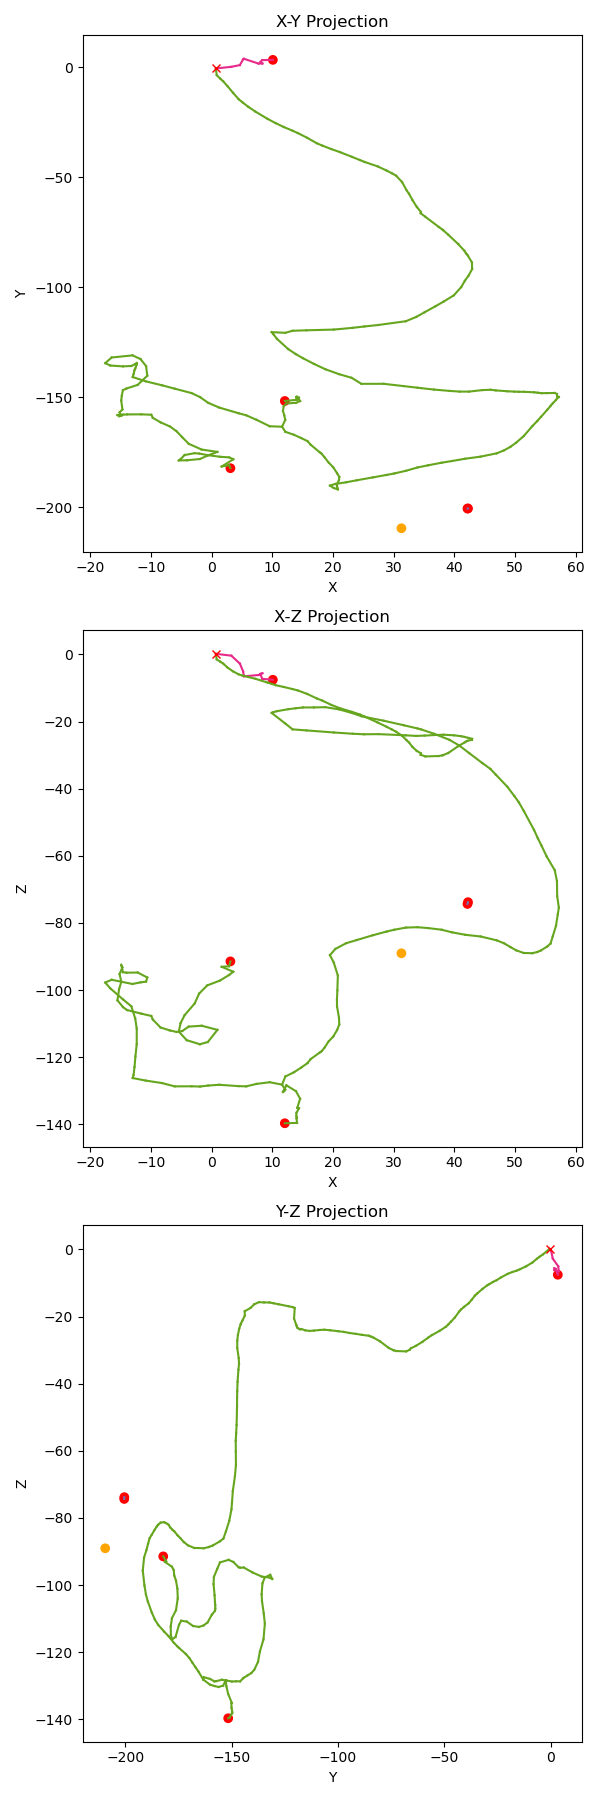

In [24]:
# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' if connection_count[i] == 1 else 'Orange' for i in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y')

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z')

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()